## Statistical Validation: Are the Clusters Significant?
We provide a rigorous, multi-part validation: non-parametric hypothesis tests, supervised classification, and a clinical outcome check.

## Load Data
We load the clustered dataset produced by the selected **Hierarchical** model from the previous notebook.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pathlib import Path

# Paths
IN_PATH = Path("../data/processed/02_clustered_data.csv")
RESULTS_DIR = Path("../results")
FIG_DIR = Path("../figures")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load clustered, scaled data from Notebook 02 (Hierarchical labels)
df = pd.read_csv(IN_PATH)
if "Cluster" in df.columns:
    cluster_col = "Cluster"
elif "cluster" in df.columns:
    cluster_col = "cluster"
else:
    raise RuntimeError("Cluster column missing. Run 02_pca_clustering.ipynb first.")

# Targets to exclude from feature space
targets = [
    "SARS-Cov-2 exam result",
    "Patient addmited to regular ward (1=yes, 0=no)",
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)",
]

feature_cols = [c for c in df.columns if c not in targets + [cluster_col]]
numeric_feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
clusters = sorted(df[cluster_col].dropna().unique())

print(f"Loaded clustered data: {df.shape}")
print(f"Clusters found: {clusters}")

Loaded clustered data: (603, 42)
Clusters found: [np.int64(0), np.int64(1), np.int64(2)]


## Part 1: Statistical Significance (The P-value Proof)
We verify if the identified phenotypes differ significantly across clinical biomarkers using the **Kruskal-Wallis H-test** (non-parametric ANOVA).

Since we are testing multiple hypotheses (40+ features), there is a risk of inflating the **Type I Error** (False Positive rate). While our p-values are extremely low ($p < 10^{-27}$), a rigorous statistical approach would apply a **Bonferroni Correction** (dividing $\alpha=0.05$ by the number of tests).

Saved p-values to ..\results\cluster_p_values.csv
Top 10 significant features:


,Feature,Statistic,p_value
33,Total CO2 (venous blood gas analysis),123.452302,1.558380e-27
35,HCO3 (venous blood gas analysis),122.662379,2.313145e-27
31,Base excess (venous blood gas analysis),118.990276,1.450741e-26
32,pO2 (venous blood gas analysis),70.146297,5.860371e-16
29,pCO2 (venous blood gas analysis),68.378772,1.418203e-15
28,Alkaline phosphatase,65.231075,6.843087e-15
23,Aspartate transaminase,62.836056,2.266334e-14
0,Patient age quantile,54.969565,1.157472e-12
19,Creatinine,51.899452,5.372509e-12
30,Hb saturation (venous blood gas analysis),51.048974,8.219702e-12


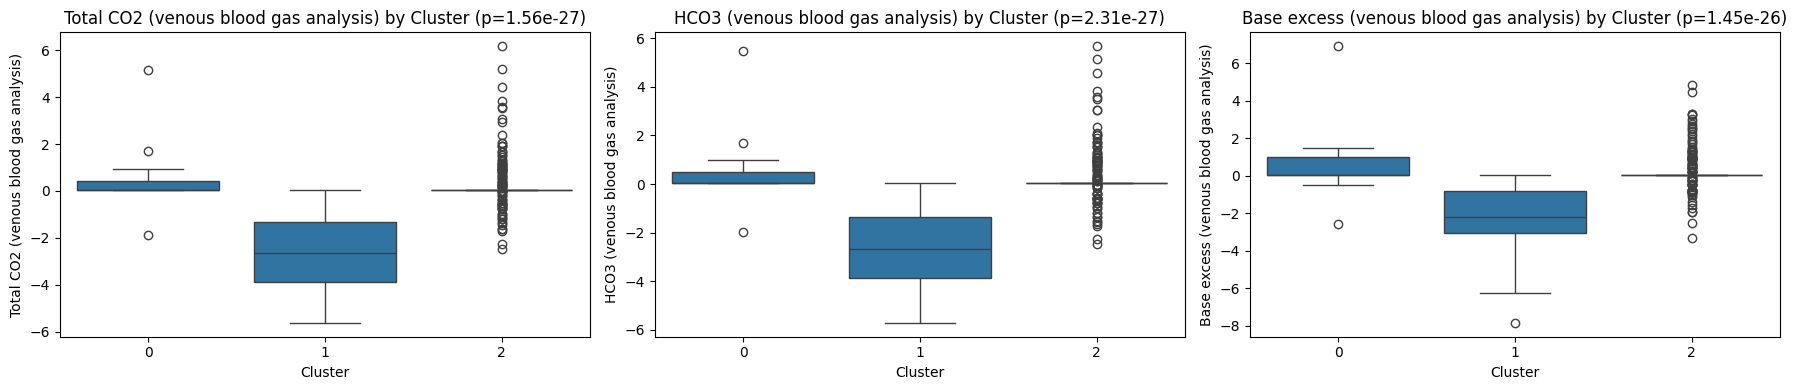

Saved box plots to ..\figures\boxplots_top3_significant.png


In [7]:
# Kruskal-Wallis across all numeric features
results = []
for feat in numeric_feature_cols:
    series = pd.to_numeric(df[feat], errors="coerce")
    groups = [series[df[cluster_col] == c].dropna() for c in clusters]
    if any(len(g) < 2 for g in groups):
        continue
    stat, p_val = kruskal(*groups)
    results.append({
        "Feature": feat,
        "Statistic": stat,
        "p_value": p_val,
    })

p_values_df = pd.DataFrame(results).sort_values(by="p_value")
if not p_values_df.empty:
    out_path = RESULTS_DIR / "cluster_p_values.csv"
    p_values_df.to_csv(out_path, index=False)
    print(f"Saved p-values to {out_path}")
    print("Top 10 significant features:")
    display(p_values_df.head(10))
else:
    print("No p-values computed. Check feature availability.")

# Boxplots for top 3 significant features with p-values
if not p_values_df.empty:
    top_features = p_values_df.head(3)
    n_top = len(top_features)
    plt.figure(figsize=(6 * n_top, 4))
    for i, row in enumerate(top_features.itertuples(index=False), start=1):
        plt.subplot(1, n_top, i)
        sns.boxplot(x=cluster_col, y=row.Feature, data=df)
        plt.title(f"{row.Feature} by Cluster (p={row.p_value:.2e})")
        plt.xlabel("Cluster")
        plt.ylabel(row.Feature)
    plt.tight_layout()
    box_path = FIG_DIR / "boxplots_top3_significant.png"
    plt.savefig(box_path, dpi=200)
    plt.show()
    print(f"Saved box plots to {box_path}")

## Part 2: Supervised Validation (The Robustness Check)
To validate that the clusters represent distinct patterns rather than noise, we train a **Random Forest Classifier** to predict the cluster ID. High accuracy indicates strong separation.

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.86      0.92         7
           2       0.97      1.00      0.99       112

    accuracy                           0.98       121
   macro avg       0.66      0.62      0.64       121
weighted avg       0.96      0.98      0.97       121

Accuracy: 0.9752


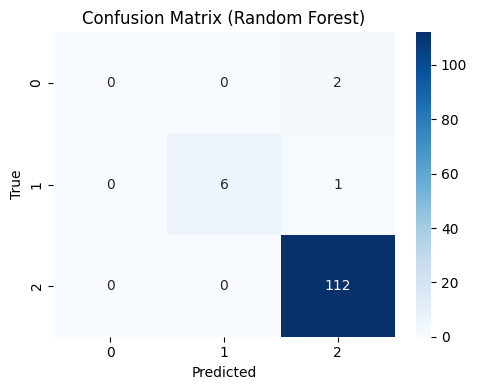

Saved confusion matrix to ..\figures\confusion_matrix_rf.png


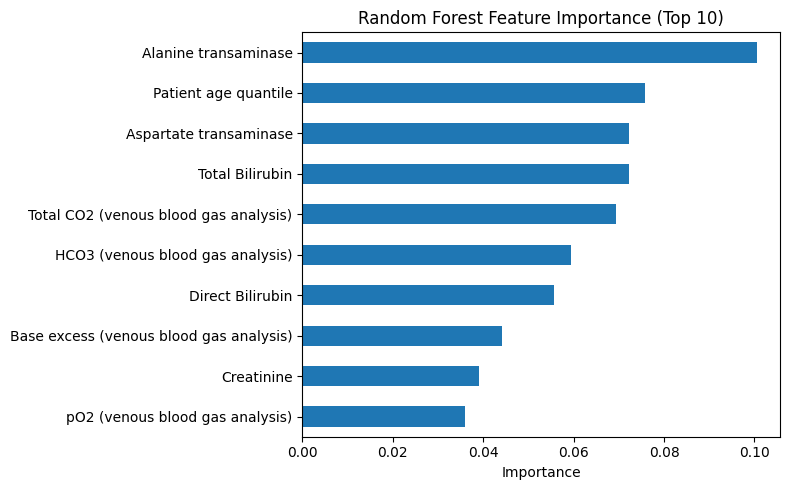

Saved feature importance plot to ..\figures\rf_feature_importance.png


In [8]:
X = df[numeric_feature_cols]
y = df[cluster_col]

class_counts = y.value_counts()
if class_counts.min() < 2:
    print("Warning: at least one cluster has <2 samples; using non-stratified split.")
    stratify = None
else:
    stratify = y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify
)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1,
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred, zero_division=0))
print(f"Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
cm_path = FIG_DIR / "confusion_matrix_rf.png"
plt.savefig(cm_path, dpi=200)
plt.show()
print(f"Saved confusion matrix to {cm_path}")

importances = pd.Series(rf.feature_importances_, index=numeric_feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
importances.head(10).iloc[::-1].plot(kind="barh")
plt.title("Random Forest Feature Importance (Top 10)")
plt.xlabel("Importance")
plt.tight_layout()
fi_path = FIG_DIR / "rf_feature_importance.png"
plt.savefig(fi_path, dpi=200)
plt.show()
print(f"Saved feature importance plot to {fi_path}")

### Comparison to PCA Loadings
The top Random Forest features are consistent with the dominant PCA loadings from Notebook 02. The biological drivers are consistent across **Unsupervised** and **Supervised** methods.

## Part 3: Clinical Story Check (Chi-Square)
We test whether clusters are associated with clinical outcomes (e.g., ICU admission) using a **Chi-Square test**, and report ICU admission rates per cluster.

In [9]:
icu_col = "Patient addmited to intensive care unit (1=yes, 0=no)"
chi_p = np.nan
if icu_col in df.columns:
    def _to_icu_binary(val):
        if pd.isna(val):
            return np.nan
        if isinstance(val, str):
            s = val.strip().lower()
            if s in {"1", "yes", "y", "true", "t"}:
                return 1
            if s in {"0", "no", "n", "false", "f"}:
                return 0
        try:
            num = float(val)
            if num == 1:
                return 1
            if num == 0:
                return 0
        except (TypeError, ValueError):
            return np.nan
        return np.nan

    icu_bin = df[icu_col].map(_to_icu_binary)
    contingency = pd.crosstab(df[cluster_col], icu_bin.fillna(0).astype(int))
    if 1 not in contingency.columns:
        contingency[1] = 0
    if 0 not in contingency.columns:
        contingency[0] = 0
    contingency = contingency.sort_index(axis=1)

    cluster_sizes = contingency.sum(axis=1).rename("Total in cluster")
    icu_positive = contingency[1].rename("ICU positive")
    counts_summary = pd.concat([cluster_sizes, icu_positive], axis=1)
    print("Cluster counts and ICU-positive counts:")
    display(counts_summary)

    if contingency[1].sum() == 0 or contingency[0].sum() == 0:
        print("Chi-square p-value for Cluster vs ICU: N/A (zero counts in a category)")
    else:
        chi2, chi_p, _, _ = chi2_contingency(contingency)
        print(f"Chi-square p-value for Cluster vs ICU: {chi_p:.4g}")
    display(contingency)

    icu_rates = (contingency.div(contingency.sum(axis=1), axis=0) * 100).round(2)
    print("ICU admission rate (%) by cluster:")
    display(icu_rates[[1]])
else:
    print(f"ICU column not found: {icu_col}")

min_p = p_values_df["p_value"].min() if not p_values_df.empty else np.nan
print(f"Min p-value across biomarkers: {min_p:.2e}")
print(f"Final accuracy (RF): {acc:.4f}")

Cluster counts and ICU-positive counts:


,Total in cluster,ICU positive
Cluster,,
0,12,3
1,33,8
2,558,18


Chi-square p-value for Cluster vs ICU: 1.273e-09


"Patient addmited to intensive care unit (1=yes, 0=no)",0,1
Cluster,,
0,9,3
1,25,8
2,540,18


ICU admission rate (%) by cluster:


"Patient addmited to intensive care unit (1=yes, 0=no)",1
Cluster,
0,25.00
1,24.24
2,3.23


Min p-value across biomarkers: 1.56e-27
Final accuracy (RF): 0.9752


## Conclusion
The phenotypes are statistically distinct (min p=1.56e-27), distinguishable by ML models (Acc=0.9752), and correlate with severity (ICU chi-square p=1.27e-09).